# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';',low_memory=False)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',low_memory=False)

I start from the `azdias` data, first show the summarized info:

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [ ]:
azdias.describe()

Display the first 5 rows:

In [6]:
display(azdias.head())

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


From the first glance, there are 366 cloumns in the `azdias` dataset, which means 366 attributes, and lots of missing values (`NaN`) in each attributes. I think the first step is to fingure out what does each attribute mean.

After review the `DIAS Attributes - Values 2017.xlsx` file, I found some attributes are not well explained, such as `AKT_DAT_KL`, also some attributes has missing values which is not `NaN`, such as `-1` in `AGER_TYP`. 

So I parsed a `.csv` from `DIAS Attributes - Values 2017.xlsx`, which lists all missing values for each attribute.

In [16]:
def summary_missing_value(inputPath, outputPath):
    # load the attrbutes values summary .xlsx file
    attributes_values = pd.read_excel(inputPath, sheet_name='Tabelle1')
    
    
    # drop first meaningless column
    attributes_values.drop(columns = ['Unnamed: 0'], inplace = True)
    
    # get all attributes names with description and value meaning:
    attributes_names = attributes_values.dropna()[['Attribute','Description','Meaning']]

    # get all attributes with unknow meaning
    attributes_values_unknown = attributes_values[attributes_values.Meaning.isin(['unknown','unknown / no main age detectable'])][['Attribute','Value']]
    
    # there are two attributes which is special 'RELAT_AB' 'KBA05_AUTOQUOT'
    attributes_values_unknown.dropna(inplace=True)
    
    attributes_values_unknown.loc[len(attributes_values_unknown)] = ['RELAT_AB','-1,9']
    
    attributes_values_unknown.loc[len(attributes_values_unknown)] = ['KBA05_AUTOQUOT','-1,9']
    
    # Merge attributes_names with attributes_values_unknown
    attributes_missing_values = pd.merge(attributes_names,attributes_values_unknown,on = ['Attribute'],how = 'outer')
    print(attributes_missing_values.shape)
    # rename the Value column to Missing Value
    attributes_missing_values.rename(columns={"Value": "Missing Value"},inplace=True)
    
    # save 
    attributes_missing_values.to_csv(outputPath,index = None)

In [17]:
file = 'DIAS Attributes - Values 2017.xlsx'
outfile = 'attributes_missing_values.csv'
summary_missing_value(file, outfile)
attributes_missing_values = pd.read_csv(outfile)
attributes_missing_values_attributes = attributes_missing_values.Attribute.values
attributes_missing_values_attributes.shape

(314, 4)


(314,)

Now I can use this `.csv` file with the `azdias` dataset to convert all missing\unknown value to `NaN`

In [18]:
azdias_copy = azdias.copy()
azdias_copy.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)

In [19]:
# get all attributes name
column_names = azdias_copy.columns.values

In [20]:
def nan_list_func(attribute_name):
    '''
    Get the missing_or_unknown value list from attributes_missing_values.
    
    <INPUT>
    attribute_name: attribute name in attributes_missing_values    
    
    <OUTPUT>
    missing_value_list:  the string value list that should be substituted as np.nan
    
    '''
    missing_str = str(attributes_missing_values[attributes_missing_values['Attribute'] == attribute_name]['Missing Value'].iloc[0]).replace(' ', '')
    missing_value_list = missing_str.split(',')   
    
    return missing_value_list


def int_float_fix(obj):
    '''
    Purpose: for an object that is float type, return the string integer to assure the substituting process works well.
    For the other types, return the string type. (nan is remain as nan)
    Ex: 
    3.0 -> '3'
    5.0 -> '5'
    nan -> nan
    'XX' -> 'XX'
    2 -> '2'
    
    <INPUT>
    objects with the following types: int, float, str
    
    <OUTPUT>
    str object
    
    '''
    if type(obj) == str or pd.isnull(obj):
        return obj
    else:
        return str(int(obj))

In [21]:
i = 0
for column_name in column_names:
    if column_name in attributes_missing_values_attributes:
        i = i + 1 
        print(i, column_name) # debug
        missing_value_list = nan_list_func(column_name)
        azdias_copy[column_name] = azdias_copy[column_name].map(lambda x: np.nan if int_float_fix(x) in missing_value_list else x)


1 AGER_TYP
2 ALTER_HH
3 ANZ_HAUSHALTE_AKTIV
4 ANZ_HH_TITEL
5 ANZ_PERSONEN
6 ANZ_TITEL
7 BALLRAUM
8 CAMEO_DEU_2015
9 CAMEO_DEUG_2015
10 CJT_GESAMTTYP
11 D19_BANKEN_ANZ_12
12 D19_BANKEN_ANZ_24
13 D19_BANKEN_DATUM
14 D19_BANKEN_OFFLINE_DATUM
15 D19_BANKEN_ONLINE_DATUM
16 D19_BANKEN_ONLINE_QUOTE_12
17 D19_GESAMT_ANZ_12
18 D19_GESAMT_ANZ_24
19 D19_GESAMT_DATUM
20 D19_GESAMT_OFFLINE_DATUM
21 D19_GESAMT_ONLINE_DATUM
22 D19_GESAMT_ONLINE_QUOTE_12
23 D19_KONSUMTYP
24 D19_TELKO_ANZ_12
25 D19_TELKO_ANZ_24
26 D19_TELKO_DATUM
27 D19_TELKO_OFFLINE_DATUM
28 D19_TELKO_ONLINE_DATUM
29 D19_VERSAND_ANZ_12
30 D19_VERSAND_ANZ_24
31 D19_VERSAND_DATUM
32 D19_VERSAND_OFFLINE_DATUM
33 D19_VERSAND_ONLINE_DATUM
34 D19_VERSAND_ONLINE_QUOTE_12
35 D19_VERSI_ANZ_12
36 D19_VERSI_ANZ_24
37 EWDICHTE
38 FINANZ_ANLEGER
39 FINANZ_HAUSBAUER
40 FINANZ_MINIMALIST
41 FINANZ_SPARER
42 FINANZ_UNAUFFAELLIGER
43 FINANZ_VORSORGER
44 FINANZTYP
45 GEBAEUDETYP
46 GEBAEUDETYP_RASTER
47 GEBURTSJAHR
48 GFK_URLAUBERTYP
49 GREEN_AVANTGARD

In [22]:
azdias_copy.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [23]:
azdias_copy.to_csv('azdias_with_all_nans.csv', index = False)
#azdias_copy = pd.read_csv('azdias_with_alll_nans.csv')

Text(0, 0.5, 'number of columns')

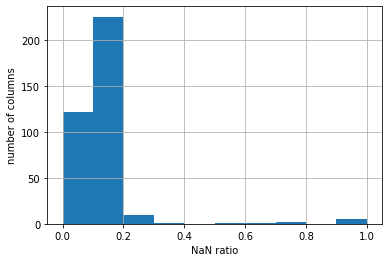

In [24]:
# caculate NaN ratio of each columns
nan_ratio_column_wise = (azdias_copy.isnull().sum() / len(azdias_copy)).sort_values(ascending=False)
nan_ratio_column_wise.hist()

plt.xlabel("NaN ratio")
plt.ylabel("number of columns")

From the histgram, most of the columns have less than 30% of missing data. 

In [25]:
outlier_column_names = nan_ratio_column_wise[nan_ratio_column_wise.values > 0.3].index
outlier_column_names
# Delete the outlier columns that have more than 30% missing data
column_cleaned_azdias = azdias_copy.drop(outlier_column_names, axis = 1)
column_cleaned_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


Now there are 356 attributes left in the dataset after the drop. In order to proceed to data engineering and transforming step, all attributes should be assigned to the following types: `categorical`, `numerical`, `ordinal`, `binary`. For this step, I have manually created `attributes_type_merged_action.csv` file with attribute names, types, action (keep, drop, one-hot or engineering)(keep is default NaN).

Since not all of the columns were provided with description,To make it simple, I will drop all the columns which are not explained in the description file.

In [26]:
column_cleaned_azdias.to_csv('column_cleaned_azdias.csv',index=False)

In [27]:
#column_cleaned_azdias = pd.read_csv('column_cleaned_azdias.csv')

In [28]:
column_cleaned_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [29]:
column_cleaned_azdias_column_names = column_cleaned_azdias.columns.values
notexplained_columns = []
for column_name in column_cleaned_azdias_column_names:
    if column_name not in attributes_missing_values_attributes:
        notexplained_columns.append(column_name)

In [30]:
column_cleaned_azdias_without_notexplained = column_cleaned_azdias.drop(columns=notexplained_columns)

In [31]:
column_cleaned_azdias_without_notexplained.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,...,3,1,NaN,NaN,NaN,NaN,NaN,3,1,2
1,11.0,0.0,2.0,0.0,6.0,8A,8,5.0,0,0,...,6,1,3.0,2.0,3.0,9.0,4.0,5,2,1
2,10.0,0.0,1.0,0.0,2.0,4C,4,3.0,0,0,...,3,4,2.0,1.0,3.0,9.0,2.0,5,2,3
3,1.0,0.0,0.0,0.0,4.0,2A,2,2.0,0,0,...,4,4,1.0,1.0,NaN,9.0,7.0,3,2,4
4,3.0,0.0,4.0,0.0,2.0,6B,6,5.0,3,5,...,2,7,2.0,2.0,2.0,9.0,3.0,4,1,3


In [32]:
column_cleaned_azdias_without_notexplained.to_csv('column_cleaned_azdias_without_notexplained.csv', index=None)
#column_cleaned_azdias_without_notexplained = pd.read_csv('column_cleaned_azdias_without_notexplained.csv')

In [33]:
def merge_attributes_type(attributes_type, attributes_type_merged):
    left_column_df = pd.DataFrame(column_cleaned_azdias_without_notexplained.columns.values, columns=['Attribute'])
    attribute_type_df = pd.read_csv(attributes_type)
    attribute_type_df['Action'] = ''
    merged_df = left_column_df.merge(attribute_type_df, how='left')
    merged_df.to_csv(attributes_type_merged, index=None)


In [34]:
attributes_type_merged_action = pd.read_csv('attributes_type_merged_action.csv')
attributes_type_merged_action.Action.value_counts(dropna=False)

NaN         248
onehot       15
engineer      4
drop          1
Name: Action, dtype: int64

## Drop all the columns which are marked as `drop` in the`action` column

In [35]:
# get the attribute names which need to be dropped
drop_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'drop'].Attribute.values

In [36]:
# drop attributes
column_cleaned_azdias_without_notexplained = column_cleaned_azdias_without_notexplained.drop(columns=drop_columns)
column_cleaned_azdias_without_notexplained.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,10,...,3,1,NaN,NaN,NaN,NaN,NaN,3,1,2
1,11.0,0.0,2.0,0.0,6.0,8,5.0,0,0,10,...,6,1,3.0,2.0,3.0,9.0,4.0,5,2,1
2,10.0,0.0,1.0,0.0,2.0,4,3.0,0,0,10,...,3,4,2.0,1.0,3.0,9.0,2.0,5,2,3
3,1.0,0.0,0.0,0.0,4.0,2,2.0,0,0,10,...,4,4,1.0,1.0,NaN,9.0,7.0,3,2,4
4,3.0,0.0,4.0,0.0,2.0,6,5.0,3,5,5,...,2,7,2.0,2.0,2.0,9.0,3.0,4,1,3


## Transform columns which are marked as `engineer` in the `action` column

There are several attributes which can be re-engineered to new attributes: `OST_WEST_KZ`, `PRAEGENDE_JUGENDJAHRE`, `WOHNLAGE`,`PLZ8_BAUMAX`.

In [37]:
#column_cleaned_azdias_without_notexplained.to_csv('column_cleaned_azdias_without_notexplained.csv', index=None)
#column_cleaned_azdias_without_notexplained = pd.read_csv('column_cleaned_azdias_without_notexplained.csv')

In [38]:
# get the attribute names which need to be onehot encode
engineer_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'engineer'].Attribute.values
engineer_columns

array(['OST_WEST_KZ', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'],
      dtype=object)

1. OST_WEST_KZ feature was encoded as 0 for Ost and 1 for West moving pattern.

In [39]:
column_cleaned_azdias_without_notexplained.OST_WEST_KZ.value_counts(dropna=False)

W      629528
O      168545
NaN     93148
Name: OST_WEST_KZ, dtype: int64

In [40]:
def OST_WEST_KZ_Engineer(x):
    x = str(x)
    if x == 'W':
        return 1
    elif x == "O":
        return 0
    else:
        return np.nan

In [41]:
column_cleaned_azdias_without_notexplained.OST_WEST_KZ = column_cleaned_azdias_without_notexplained.OST_WEST_KZ.apply(OST_WEST_KZ_Engineer)
column_cleaned_azdias_without_notexplained.OST_WEST_KZ.value_counts(dropna=False)

1.0    629528
0.0    168545
NaN     93148
Name: OST_WEST_KZ, dtype: int64

2. PRAEGENDE_JUGENDJAHRE —> MOVEMENT (1: Mainstream, 2: Avantgarde) and GENERATION_DECADE (4: 40s, 5: 50s, 6: 60s, 7: 70s, 8: 80s, 9: 90s)

In [42]:
column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.value_counts(dropna=False)

14.0    188697
8.0     145988
NaN     108164
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [43]:
def PRAEGENDE_JUGENDJAHRE_MOVEMENT_Engineer(x):
    if x in (1,3,5,8,10,12,14):
        return 1
    elif x in (2,4,6,7,11,13,15):
        return 2
    else:
        return np.nan


def PRAEGENDE_JUGENDJAHRE_GENERATION_DECADE_Engineer(x):
    if x in (1,2):
        return 4
    elif x in (3,4):
        return 5
    elif x in (5,6,7):
        return 6
    elif x in (8,9):
        return 7
    elif x in (10,11,12,13):
        return 8
    elif x in (14,15):
        return 9
    else:
        return np.nan        

In [44]:
movement = column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.apply(PRAEGENDE_JUGENDJAHRE_MOVEMENT_Engineer)
movement.value_counts(dropna=False)

1.0    607832
NaN    141734
2.0    141655
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [45]:
generation_decade = column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.apply(PRAEGENDE_JUGENDJAHRE_GENERATION_DECADE_Engineer)
generation_decade.value_counts(dropna=False)

9.0    231244
7.0    179558
8.0    151770
6.0    116078
NaN    108164
5.0     75646
4.0     28761
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [46]:
column_cleaned_azdias_without_notexplained['MOVEMENT'] = movement
column_cleaned_azdias_without_notexplained['GENERATION_DECADE'] = generation_decade

In [47]:
column_cleaned_azdias_without_notexplained.shape

(891221, 269)

3. WOHNLAGE —> RURAL_NEIGBORHOOD (0: Not Rural, 1: Rural)

In [48]:
column_cleaned_azdias_without_notexplained.WOHNLAGE.value_counts(dropna=False)

3.0    249719
7.0    169318
4.0    135973
2.0    100376
NaN     93148
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64

In [49]:
def WOHNLAGE_RURAL_NEIGBORHOOD_engineer(x):
    if x in (0,1,2,3,4,5):
        return 0
    elif x in (7,8):
        return 1
    else:
        return np.nan

In [50]:
rural_neighboorhood = column_cleaned_azdias_without_notexplained.WOHNLAGE.apply(WOHNLAGE_RURAL_NEIGBORHOOD_engineer)
rural_neighboorhood.value_counts(dropna=False)

0.0    611282
1.0    186791
NaN     93148
Name: WOHNLAGE, dtype: int64

In [51]:
column_cleaned_azdias_without_notexplained['RURAL_NEIGBORHOOD'] = rural_neighboorhood

In [52]:
column_cleaned_azdias_without_notexplained.shape

(891221, 270)

4. PLZ8_BAUMAX —> PLZ8_BAUMAX_FAMILY (0: 0 families, 1: mainly 1–2 family homes, 2: mainly 3–5 family homes, 3: mainly 6–10 family homes, 4: mainly 10+ family homesand PLZ8_BAUMAX_BUSINESS (0: Not Business, 1: Business)

In [53]:
column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.value_counts(dropna=False)

1.0    499550
NaN    116515
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [54]:
def PLZ8_BAUMAX_PLZ8_BAUMAX_FAMILY_Engineer(x):
    if x in (1,2,3,4):
        return x
    elif x == 5:
        return 0
    else:
        return np.nan


def PLZ8_BAUMAX_PLZ8_BAUMAX_BUSINESS_Engineer(x):
    if x in (1,2,3,4):
        return 0
    elif x == 5:
        return 1
    else:
        return np.nan 

In [55]:
family = column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.apply(PLZ8_BAUMAX_PLZ8_BAUMAX_FAMILY_Engineer)
family.value_counts(dropna=False)

1.0    499550
NaN    116515
0.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [56]:
business = column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.apply(PLZ8_BAUMAX_PLZ8_BAUMAX_BUSINESS_Engineer)
business.value_counts(dropna=False)

0.0    677373
NaN    116515
1.0     97333
Name: PLZ8_BAUMAX, dtype: int64

In [57]:
column_cleaned_azdias_without_notexplained['PLZ8_BAUMAX_FAMILY'] = family
column_cleaned_azdias_without_notexplained['PLZ8_BAUMAX_BUSINESS'] = business

In [58]:
column_cleaned_azdias_without_notexplained.shape

(891221, 272)

### Drop the original attributes

In [59]:
column_cleaned_azdias_without_notexplained_engineered = column_cleaned_azdias_without_notexplained.drop(columns=engineer_columns)

In [60]:
column_cleaned_azdias_without_notexplained_engineered.shape

(891221, 268)

In [61]:
column_cleaned_azdias_without_notexplained_engineered.to_csv('column_cleaned_azdias_engineered.csv',index=None)

##  Onehot encode all categorical columns

In [62]:
# get the attribute names which need to be onehot encode
onehot_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'onehot'].Attribute.values

In [63]:
onehot_columns

array(['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP',
       'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP',
       'KBA05_MAXHERST', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_LEBENSPHASE_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'VERS_TYP', 'ZABEOTYP'], dtype=object)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [ ]:
!cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv Udacity_MAILOUT_052018_TRAIN.csv

In [ ]:
display(mailout_train.shape)

In [ ]:
np.where(mailout_train.ALTER_KIND1 is nan)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
!cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv Udacity_MAILOUT_052018_TEST.csv 